# Userdefined methods used to train and test KNN model

In [28]:
# generate data for n-th iteration for k-fold cross validation
def getdata_cv(Xtrain, Ytrain, k=5, n=0):
    batch_size = int(Xtrain.shape[0] / k)
    if n == 0:
        Xtrain_batch = Xtrain[batch_size:, :]
        Ytrain_batch = Ytrain[batch_size:]
        Xtest_batch = Xtrain[:batch_size, :]
        Ytest_batch = Ytrain[:batch_size]
    elif n == k-1:
        Xtrain_batch = Xtrain[:n*batch_size, :]
        Ytrain_batch = Ytrain[:n*batch_size]
        Xtest_batch = Xtrain[n*batch_size:, :]
        Ytest_batch = Ytrain[n*batch_size:]
    else:
        start_idx = n*batch_size
        end_idx = (n+1)*batch_size
        Xtrain_batch = np.concatenate((Xtrain[:start_idx, :], Xtrain[end_idx:, :]))
        Ytrain_batch = np.concatenate((Ytrain[:start_idx], Ytrain[end_idx:]))
        Xtest_batch = Xtrain[start_idx:end_idx, :]
        Ytest_batch = Ytrain[start_idx:end_idx]
    return Xtrain_batch, Ytrain_batch, Xtest_batch, Ytest_batch

def train_knn(Xtrain, Ytrain, k=5):
    loss_sum = 0
    acc_sum = 0
    for i in range(k):
        Xtrain_batch, Ytrain_batch, Xtest_batch, Ytest_batch = getdata_cv(Xtrain, Ytrain, k=k, n=i)
        #train model with k=11 as found by plot of optimal k
        model = KNeighborsRegressor(n_neighbors=11).fit(Xtrain_batch, Ytrain_batch)
        pred = model.predict(Xtest_batch)
        loss_sum += mean_squared_error(pred, Ytest_batch)
    return loss_sum/k, acc_sum/k

def accuracy(pred, gt, percentage=0.05):
    gt_upper = gt + gt * percentage
    gt_lower = gt - gt * percentage
    return np.mean((pred <= gt_upper) & (pred >= gt_lower))

# Training KNN model

In [29]:
#TRAINING KNN MODEL 

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import mean_squared_error

# Load the dataset into a pandas DataFrame
train_lda_la = pd.read_csv('la_training_lda_final.csv', index_col=['date'])
test_lda_la = pd.read_csv('la_testing_lda_final.csv', index_col=['date'])
nlp_data_la = pd.read_csv('Los_Angeles_feat.csv', index_col=['date'])

train_lda_b = pd.read_csv('b_training_lda_final.csv', index_col=['date'])
test_lda_b = pd.read_csv('b_testing_lda_final.csv', index_col=['date'])
nlp_data_b = pd.read_csv('Boston_feat.csv', index_col=['date'])

gt_la = pd.read_csv('LA22_groundtruth.csv')

gt_b = pd.read_csv('Boston22_groundtruth.csv')

gt_la['Total']= gt_la.iloc[:, 1:].sum(axis=1)
gt_la['date'] = gt_la['OCCURRED_ON_DATE'].str[:10]

gt_b['Total']= gt_b.iloc[:, 1:].sum(axis=1)
gt_b['date'] = gt_b['OCCURRED_ON_DATE'].str[:10]

gt_la = gt_la.set_index('date')
gt_b = gt_b.set_index('date')

X_train_la = train_lda_la.join(nlp_data_la)
X_test_la = test_lda_la.join(nlp_data_la)

X_train_b = train_lda_b.join(nlp_data_b)
X_test_b = test_lda_b.join(nlp_data_b)

Y_train_la = gt_la.reindex(X_train_la.index)['Total']
Y_test_la = gt_la.reindex(X_test_la.index)['Total']

Y_train_b = gt_b.reindex(X_train_b.index)['Total']
Y_test_b = gt_b.reindex(X_test_b.index)['Total']


#Train the models using 5 fold cross validation
#Los Angeles
loss_la = train_knn(X_train_la.to_numpy(), Y_train_la.to_numpy())
#Boston
loss_b = train_knn(X_train_b.to_numpy(), Y_train_b.to_numpy())

# Validation of KNN

In [30]:
#Los Angeles Model
#define percentages for prediction comparison
percentage = [0.05, 0.1, 0.2]
#Train KNN model
model_la = KNeighborsRegressor(n_neighbors=15).fit(X_train_la, Y_train_la)
#Infer test data
pred_la = model_la.predict(X_test_la)
#calculate mse
mse_loss_la = mean_squared_error(pred_la, Y_test_la)
#print results
print(mse_loss_la)
for j in range(len(percentage)):
        acc = accuracy(pred_la, Y_test_la, percentage[j])
        print(acc)

32552.634642313547
0.4520547945205479
0.7123287671232876
0.8767123287671232


In [31]:
#Boston
#define percentages for prediction comparison
percentage = [0.05, 0.1, 0.2]
#Train KNN model
model_b = KNeighborsRegressor(n_neighbors=15).fit(X_train_b, Y_train_b)
#Infer test data
pred_b = model_b.predict(X_test_b)
#calculate mse
mse_loss_b = mean_squared_error(pred_b, Y_test_b)
#print results
print(mse_loss_b)
for j in range(len(percentage)):
        acc = accuracy(pred_b, Y_test_b, percentage[j])
        print(acc)

2386.0286149162857
0.2054794520547945
0.5753424657534246
0.9178082191780822


# Appendix: Finding Optimal K

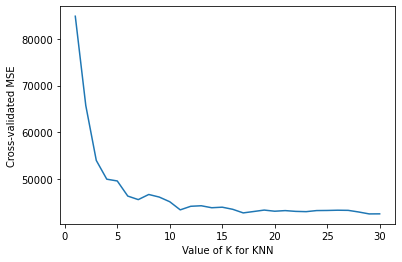

In [37]:
import matplotlib.pyplot as plt
import numpy as np
#kfold cross validation
kfold = 5
#define range of k to test [1 to 30]
k_range = range(1,31)
# Create an empty list to store the cross-validation scores
k_scores = []

#FOR LA-
Xtrain = X_train_la
Ytrain = Y_train_la
#FOR BOSTON (uncomment)
#Xtrain = X_train_b
#Ytrain = Y_train_b

# Test each value of k
for k in k_range:
    loss_sum = 0
    for i in range(kfold):
        Xtrain_batch, Ytrain_batch, Xtest_batch, Ytest_batch = getdata_cv(Xtrain.to_numpy(), Ytrain.to_numpy(), k=kfold, n=i)
        model = KNeighborsRegressor(n_neighbors=k).fit(Xtrain_batch, Ytrain_batch)
        pred = model.predict(Xtest_batch)
        loss_sum += mean_squared_error(pred, Ytest_batch)
    k_scores.append(loss_sum/kfold)

# Plot the values of k vs the cross-validation scores
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated MSE')
plt.show()